In [1]:
from __future__ import division, print_function # python3 compatibilty

import numpy as np                  # import numpy
from time import time               # use for timing functions

# useful modules!
import sys
import os
import six

# make the plots look a bit nicer with some defaults
from matplotlib import pyplot as pl # import pyplot from matplotlib
import matplotlib as mpl
rcparams = {}
rcparams['text.usetex'] = True
rcparams['axes.linewidth'] = 0.5
rcparams['font.family'] = 'sans-serif'
rcparams['font.size'] = 22

# functions for plotting posteriors
import corner
from scipy.stats import gaussian_kde

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3
 5.4 5.5 5.6 5.7 5.8 5.9 6.  6.1 6.2 6.3 6.4 6.5 6.6 6.7 6.8 6.9 7.  7.1
 7.2 7.3 7.4 7.5 7.6 7.7 7.8 7.9 8.  8.1 8.2 8.3 8.4 8.5 8.6 8.7 8.8 8.9
 9.  9.1 9.2 9.3 9.4 9.5 9.6 9.7 9.8 9.9]


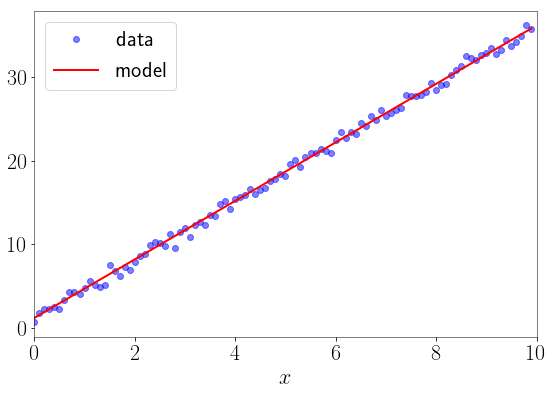

In [16]:
m = 3.5 # gradient of the line
c = 1.2 # y-intercept of the line

# set the "predictor variable"/abscissa
M = 100
xmin = 0.
xmax = 10.
stepsize = (xmax-xmin)/M
x = np.arange(xmin, xmax, stepsize)
print(x)

# define the model function
def straight_line(x, m, c):
    """
    A straight line model: y = m*x + c
    
    Args:
        x (list): a set of abscissa points at which the model is defined
        m (float): the gradient of the line
        c (float): the y-intercept of the line
    """

    return m*x + c

# seed our random number generator, so we have reproducible data
np.random.seed(sum([ord(v) for v in 'samplers']))

# create the data - the model plus Gaussian noise
sigma = 0.5 # standard deviation of the noise
data = straight_line(x, m, c) + sigma*np.random.randn(M)

# plot the data
mpl.rcParams.update(rcparams) # update plot parameters
fig, ax = pl.subplots(figsize=(9,6))
ax.plot(x, data, 'bo', alpha=0.5, label='data')
ax.plot(x, straight_line(x, m, c), 'r-', lw=2, label='model')
ax.legend()
ax.set_xlim([xmin, xmax])
ax.set_xlabel(r'$x$');


In [3]:
def logposterior(theta, data, sigma, x):
    """
    The natural logarithm of the joint posterior.

    Args:
        theta (tuple): a sample containing individual parameter values
        data (list): the set of data/observations
        sigma (float): the standard deviation of the data points
        x (list): the abscissa values at which the data/model is defined
    """

    lp = logprior(theta) # get the prior

    # if the prior is not finite return a probability of zero (log probability of -inf)
    if not np.isfinite(lp):
        return -np.inf

    # return the likeihood times the prior (log likelihood plus the log prior)
    return lp + loglikelihood(theta, data, sigma, x)

In [65]:
def loglikelihood(theta, data, sigma, x):
    """
    The natural logarithm of the joint likelihood.

    Args:
        theta (tuple): a sample containing individual parameter values
        data (list): the set of data/observations
        sigma (float): the standard deviation of the data points
        x (list): the abscissa values at which the data/model is defined

    Note:
        We do not include the normalisation constants (as discussed above).
    """

    # unpack the model parameters from the tuple
    m, c = theta

    # evaluate the model (assumes that the straight_line model is defined as above)
    md = straight_line(x, m, c)

    # return the log likelihood
    return -0.5*np.sum(((md - data)/sigma)**2)

In [5]:
def logprior(theta):
    """
    The natural logarithm of the prior probability.

    Args:
        theta (tuple): a sample containing individual parameter values

    Note:
        We can ignore the normalisations of the prior here.
    """

    lp = 0.

    # unpack the model parameters from the tuple
    m, c = theta

    # uniform prior on c
    cmin = -10. # lower range of prior
    cmax = 10.  # upper range of prior

    # set prior to 1 (log prior to 0) if in the range and zero (-inf) outside the range 
    lp = 0. if cmin < c < cmax else -np.inf

    # Gaussian prior on m
    mmu = 0.     # mean of the Gaussian prior
    msigma = 10. # standard deviation of the Gaussian prior
    lp -= 0.5*((m - mmu)/msigma)**2

    return lp

In [6]:
Nens = 100   # number of ensemble points

mmu = 0.     # mean of the Gaussian prior
msigma = 10. # standard deviation of the Gaussian prior

mini = np.random.normal(mmu, msigma, Nens) # initial m points

cmin = -10.  # lower range of prior
cmax = 10.   # upper range of prior

cini = np.random.uniform(cmin, cmax, Nens) # initial c points

inisamples = np.array([mini, cini]).T # initial samples

ndims = inisamples.shape[1] # number of parameters/dimensions

In [7]:
Nburnin = 500   # number of burn-in samples
Nsamples = 500  # number of final posterior samples

In [8]:
import emcee # import the emcee package

print('emcee version: {}'.format(emcee.__version__))

# set additional args for the posterior (the data, the noise std. dev., and the abscissa)
argslist = (data, sigma, x)

# set up the sampler
sampler = emcee.EnsembleSampler(Nens, ndims, logposterior, args=argslist)

emcee version: 2.2.1


In [9]:
# pass the initial samples and total number of samples required
t0 = time() # start time
sampler.run_mcmc(inisamples, Nsamples+Nburnin);
t1 = time()

timeemcee = (t1-t0)
print("Time taken to run 'emcee' is {} seconds".format(timeemcee))

# extract the samples (removing the burn-in)
samples_emcee = sampler.chain[:, Nburnin:, :].reshape((-1, ndims))

Time taken to run 'emcee' is 1.7319989204406738 seconds


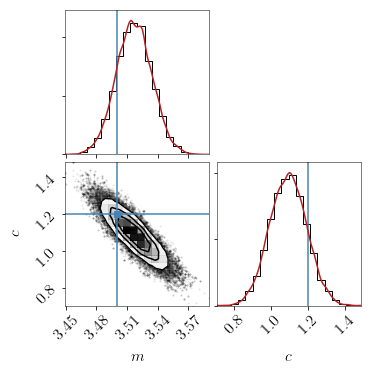

In [10]:
# plot the resulting posteriors
mpl.rcParams.update({'font.size': 16})

#def plotposts(samples, truths=[m,c]):
def plotposts(samples, **kwargs):
    """
    Function to plot posteriors using corner.py and scipy's gaussian KDE function.
    """
    if "truths" not in kwargs:
        kwargs["truths"] = [m, c]
    
    fig = corner.corner(samples, labels=[r'$m$', r'$c$'], hist_kwargs={'density': True}, **kwargs)

    # plot KDE smoothed version of distributions
    for axidx, samps in zip([0, 3], samples.T):
        kde = gaussian_kde(samps)
        xvals = fig.axes[axidx].get_xlim()
        xvals = np.linspace(xvals[0], xvals[1], 100)
        fig.axes[axidx].plot(xvals, kde(xvals), color='firebrick')

# make plot
plotposts(samples_emcee)

In [11]:
# lets store some results for showing together later
resdict = {}

resdict['memcee_mu'] = np.mean(samples_emcee[:,0])     # mean of m samples
resdict['memcee_sig'] = np.std(samples_emcee[:,0])     # standard deviation of m samples
resdict['cemcee_mu'] = np.mean(samples_emcee[:,1])     # mean of c samples
resdict['cemcee_sig'] = np.std(samples_emcee[:,1])     # standard deviation of c samples
resdict['ccemcee'] = np.corrcoef(samples_emcee.T)[0,1] # correlation coefficient between parameters

In [12]:
from emcee.utils import sample_ball
m_guess, c_guess = 1., 1. # guess at the mean of the distribution
m_std, c_std = 1., 1.     # guess at the width of the distribution

# generate samples from a ball based on those guesses
inisamples = sample_ball((m_guess, c_guess), (m_std, c_std), size=Nens)

In [13]:
# reset so we don't pick up the result from earlier
sampler.reset()

# pass the initial samples and total number of samples required
t0 = time() # start time
sampler.run_mcmc(inisamples, Nsamples+Nburnin);
t1 = time()

timeemcee = (t1-t0)
print("Time taken to run 'emcee' is {} seconds".format(timeemcee))

# extract the samples (removing the burn-in)
samples_emcee = sampler.chain[:, Nburnin:, :].reshape((-1, ndims))

Time taken to run 'emcee' is 1.8158116340637207 seconds


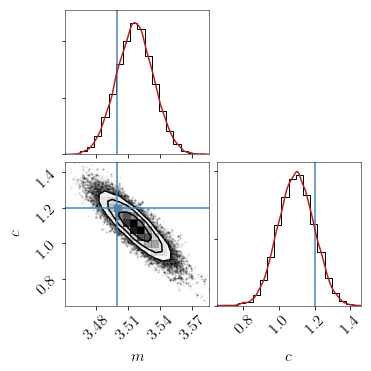

In [14]:
# plot the resulting posteriors
plotposts(samples_emcee)